In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _canoeValues as cv
import math

#-------------------Inputs-------------------------------------------------------------
# input_files = ["Shear_and_Moment_6 Paddlers.csv", "Shear_and_Moment_4 Paddlers.csv", "Shear_and_Moment_3 Paddlers.csv", "Shear_and_Moment_2 Paddlers.csv", "Shear_and_Moment_Display_Stand.csv"]
# shear_files = ["Length_vs_Shear_6 Paddler.csv", "Length_vs_Shear_4 Paddler.csv", "Length_vs_Shear_3 Paddler.csv", "Length_vs_Shear_2 Paddler.csv", "Length_vs_Shear_Display_Stand.csv", ]
input_files = ["Shear_and_Moment_6 Paddlers.csv", "Shear_and_Moment_4 Paddlers.csv", "Shear_and_Moment_2 Paddlers.csv", "Shear_and_Moment_Display_Stand.csv"]
shear_files = ["Length_vs_Shear_6 Paddler.csv", "Length_vs_Shear_4 Paddler.csv", "Length_vs_Shear_2 Paddler.csv", "Length_vs_Shear_Display_Stand.csv", ]
hf = cv.concrete_thickness # [mm]
f_c = cv.compressive_strength # [MPa]
lamda = cv.lamda
beta = cv.beta
layer1 = cv.hasLayer1 # if layer exists, it equals to 1. Otherwise, Xero.
layer2 = cv.hasLayer2 # if layer exists, it equals to 1. Otherwise, Xero.
d_mesh_1 = cv.d_mesh_1 # distance b/w the first layer of reinforcement to the surface [mm]
d_mesh_2 = cv.d_mesh_2 # distance b/w the second layer of reinforcement to the surface [mm]
concrete_thickness = cv.concrete_thickness
#-----------Reinforcement Property-------------
phi_s = cv.phi_s
fy = cv.fy # [MPa]
phi_c = cv.phi_c
E_s = cv.E_s # [MPa]
layer_unit_1 = cv.layer_unit_1 # one lap for layer 1 [mm^2/m]
layer_unit_2 = cv.layer_unit_2 # one lap for layer 2
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('data')

inner_file = "Inner Hull.csv"
outer_file = "Outer Hull.csv"

file_path = os.path.join(script_dir, inner_file) # file path for the text file input
in_coor = pd.read_csv(file_path, header=None)

file_path = os.path.join(script_dir, outer_file) # file path for the text file input
out_coor = pd.read_csv(file_path, header=None)

# Get inner and outer hull coordinates (station points)
x_in = in_coor[0]
y_in = in_coor[1]
z_in = in_coor[2]

x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

station_no = x_out.nunique() # number of stations
station_out = x_out.unique() # location of each station
station_in = x_in.unique()


# Calculate y-bar and Q

Longitudinal Shear for Every Station:
Length_vs_Shear_6 Paddler.csv:
SBL: 0                        Shear
1                          0.0
2                          0.0
3                          0.0
4                          0.0
                 ...          
5746    -9.094947017729282e-13
5747    -9.094947017729282e-13
5748    -9.094947017729282e-13
5749    -9.094947017729282e-13
5750    -9.094947017729282e-13
Name: 2, Length: 5751, dtype: object
Max Shear Stress: 10.641007603309134 MPa
Min Shear Stress: -10.667964496807459 MPa
Avg ybar: 152.62947942628284
Max Shear Stress: 97295.51641569217 MPa
Min Shear Stress: 57156.62044597306 MPa


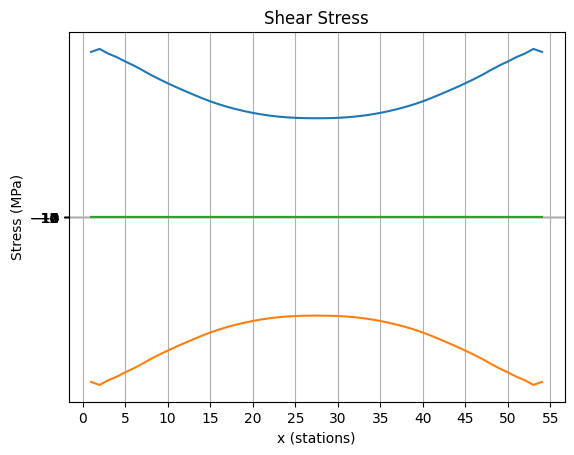

Length_vs_Shear_4 Paddler.csv:
SBL: 0                         Shear
1                           0.0
2                           0.0
3                           0.0
4                           0.0
                 ...           
5746    -1.8189894035458565e-12
5747    -1.8189894035458565e-12
5748    -1.8189894035458565e-12
5749    -1.8189894035458565e-12
5750    -1.8189894035458565e-12
Name: 2, Length: 5751, dtype: object
Max Shear Stress: 9.027816737078142 MPa
Min Shear Stress: -9.537964194915956 MPa
Avg ybar: 152.62947942628284
Max Shear Stress: 97295.51641569217 MPa
Min Shear Stress: 57156.62044597306 MPa


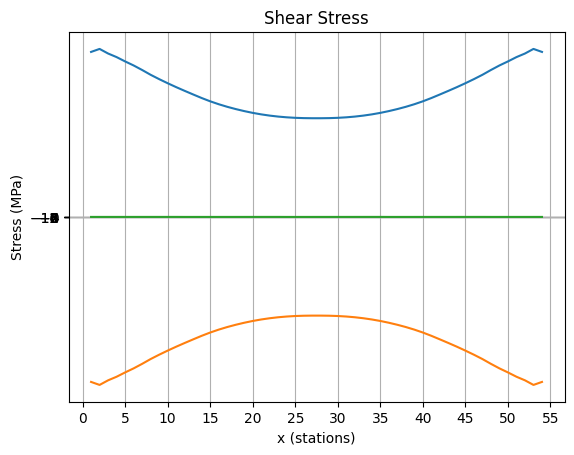

Length_vs_Shear_2 Paddler.csv:
SBL: 0                        Shear
1                          0.0
2                          0.0
3                          0.0
4                          0.0
                 ...          
5746    1.1368683772161603e-12
5747    1.1368683772161603e-12
5748    1.1368683772161603e-12
5749    1.1368683772161603e-12
5750    1.1368683772161603e-12
Name: 2, Length: 5751, dtype: object
Max Shear Stress: 13.808837987108639 MPa
Min Shear Stress: -14.020782732922706 MPa
Avg ybar: 152.62947942628284
Max Shear Stress: 97295.51641569217 MPa
Min Shear Stress: 57156.62044597306 MPa


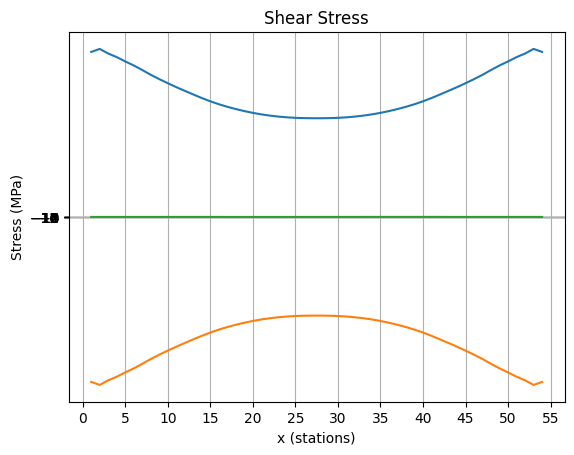

Length_vs_Shear_Display_Stand.csv:
SBL: 0                        Shear
1                          0.0
2                          0.0
3                          0.0
4                          0.0
                 ...          
5746    -6.821210263296962e-13
5747    -6.821210263296962e-13
5748    -6.821210263296962e-13
5749    -6.821210263296962e-13
5750    -6.821210263296962e-13
Name: 2, Length: 5751, dtype: object
Max Shear Stress: 6.257421422095163 MPa
Min Shear Stress: -5.904849715405806 MPa
Avg ybar: 152.62947942628284
Max Shear Stress: 97295.51641569217 MPa
Min Shear Stress: 57156.62044597306 MPa


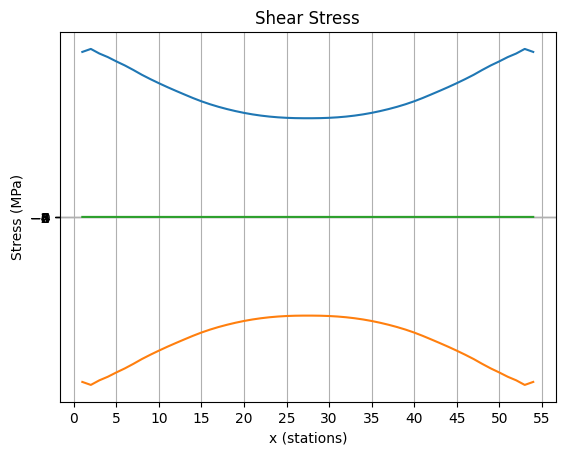

[4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323071096, 4.066207323

In [2]:
# Import cross-sectional area from Station Information.csv
script_dir = os.path.abspath('data')# absolute file path in Jupyter
file_path = os.path.join(script_dir, "Station Information.csv") # file path for the text file input
canoe_info = pd.read_csv(file_path, header=None)
crossSectionalArea = canoe_info[6][1:]

# Store each paddler case's x and shear to recreate their shear force diagrams later
PAD_CASE_STATIONS = []
PAD_CASE_LENGTH = []
PAD_CASE_SHEAR = []

shear_capacity = []
TauMaxArray = []

y_bar_total = 0

print("Longitudinal Shear for Every Station:")
# Loop through each load case
for input_file in shear_files:
    print("\033[4m" + input_file + ":\033[0m")

    # Get the shear for each station from the file
    file_path = os.path.join(script_dir, input_file)
    shearByLength = pd.read_csv(file_path, header=None)

    print("SBL:", shearByLength[2])

    shearArray = []
    for i in range(len(station_in)):
        shearArray.append(shearByLength[2][i * round(len(shearByLength[0])/len(station_in)) + 1])

    # Store each paddler case's x and shear to recreate their shear force diagrams later
    PAD_CASE_STATIONS.append(shearByLength[0][1:])
    PAD_CASE_LENGTH.append(shearByLength[1][1:])
    PAD_CASE_SHEAR.append(shearByLength[2][1:])

    # Initialize arrays to store each station's I, Q, and Tau
    # IArray = []
    # QArray = []
    TauArray = []

    # Loop through each station
    for k in range(1,station_no-2,1):

        # X-coordinates for the sides of this station
        X1_in = station_in[k]
        X2_in = station_in[k+1]
        X1_out = station_out[k]
        X2_out = station_out[k+1]
        
        # Arrays to store the YZ-coordinates of each point in the station (inner and outer hull)
        Y1_in = []; Z1_in = []
        Y2_in = []; Z2_in = []
        Y1_out = []; Z1_out = []
        Y2_out = []; Z2_out = []
        
        # Loop through each x coordinate and get every point in the cross-section
        for i in range(0,len(x_out),1):
            if x_out[i] == X1_out:
                Y1_out.append(y_out[i])
                Z1_out.append(z_out[i])

            elif x_out[i] == X2_out:
                Y2_out.append(y_out[i])
                Z2_out.append(z_out[i])
            
            if x_in[i] == X1_in:
                Y1_in.append(y_in[i])
                Z1_in.append(z_in[i])

            elif x_in[i] == X2_in:
                Y2_in.append(y_in[i])
                Z2_in.append(z_in[i])

        # Depth and Shear (Value) for each station
        depth = (abs(min(Z1_out))+abs(min(Z2_out)))/2
        value = float(shearArray[k])

        # Calculate the canoe's volume (intermediate step for y-bar)
        volume = 0
        product = 0 # y_bar * Volume
        for i in range(0,len(Y1_out)-1,1):
            #print("Y1 (in, out) : (" + str(Y1_in[i]) + ", " + str(Y1_out[i]) + ")\n" + "Z1 (in, out) : (" + str(Z1_in[i]) + ", " + str(Z1_out[i]) + ")")
            #print("Y2 (in, out) : (" + str(Y2_in[i]) + ", " + str(Y2_out[i]) + ")\n" + "Z2 (in, out) : (" + str(Z2_in[i]) + ", " + str(Z2_out[i]) + ")\n")
            z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
            x = (abs(X1_in-X2_in) + abs(X1_out-X2_out))/2
            y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
            z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

            volume_i = x * y * z
            volume += volume_i
            product += volume_i * z_i

        # Calculate y-bar from the top and bottom
        y_bar_top = abs(product/volume)
        y_bar_total += y_bar_top
        y_bar_bottom = depth - y_bar_top

        # Calculate I
        I = 0
        for i in range(0,len(Y1_out)-1,1):
            z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
            y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
            z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4
            I_i = (1/12*y*z**3 + y*z*(abs(z_i) - y_bar_top)**2) # [mm^4]
            I = I + I_i

        # Calculate A top (intermediate step for Q)
        A_top_total = 0 # mm^2
        A_top_ybar_product = 0

        for i in range(0,len(Y1_out)-1,1):
            z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
            y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
            z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

            if(abs(z) <= abs(y_bar_top)):
                A_top_total += y*z
                A_top_ybar_product += A_top_total * z_i

        A_top_ybar = A_top_ybar_product / A_top_total # mm

        # Calc shear capacity per station
        # Only calculate once PER LOAD CASE
        if(input_file == shear_files[0]):
            # Shear Capacity (per station) = 0.17 * √(Compressive Strength) * A_top
            # print("A Top:", A_top_total)
            # <?><?><?> b_w = 9, 
            shear_capacity.append(0.17 * math.sqrt(cv.compressive_strength) * lamda * 9 * 0.9 * 8 * phi_c * beta) # A_top_total * phi_c * beta)
                                                                        # √MPa * mm^2 => kN

            Q = A_top_total * abs(A_top_ybar - y_bar_top) # mm^3
            tau_max = (0.17 * math.sqrt(cv.compressive_strength) * lamda * A_top_total)*1000 * Q / (I * concrete_thickness*2) # N * mm^3 / mm^4 * mm
                                                            # N/mm^2 = MPa
            TauMaxArray.append(tau_max)


        # Calculate Q and Tau
        Q = A_top_total * abs(A_top_ybar - y_bar_top) # mm^3
        tau_positive = value * Q / (I * concrete_thickness*2) # N * mm^3 / mm^4 * mm
                                                        # N/mm^2 = MPa

        # Store this station's I, Q and Tau in arrays
        # IArray.append(I)
        # QArray.append(Q)
        TauArray.append(tau_positive)

        # print("Station", k)
        # print("I:", I, "mm^4")
        # print("Q:", Q, "mm^3")
        # print("Tau Positive: " + str(tau_positive) + " MPa\n")

    print("Max Shear Stress:", max(TauArray), "MPa")
    print("Min Shear Stress:", min(TauArray), "MPa")

    print("Avg ybar:", y_bar_total / len(range(1, station_no-2, 1)))
    y_bar_total = 0

    # Plot shear_capacity envelope
    plt.plot(range(1,station_no-2,1), [x for x in TauMaxArray])
    plt.plot(range(1,station_no-2,1), [-x for x in TauMaxArray])

    print("Max Shear Stress:", max(TauMaxArray), "MPa")
    print("Min Shear Stress:", min(TauMaxArray), "MPa")


    # Plot shear stress for each load case
    plt.plot(range(1,station_no-2,1), TauArray)
    plt.title('Shear Stress')
    plt.xticks(np.arange(0, 56, 5))
    plt.xlabel('x (stations)')
    plt.yticks(np.arange(round(min(TauArray)) - (round(min(TauArray)) % 2 + 2),round(max(TauArray)) + 1, 2))
    plt.ylabel('Stress (MPa)')
    plt.grid()
    plt.show()

print(shear_capacity)
print("Max: ", max(shear_capacity))

print(TauMaxArray)
print("Max: ", max(TauMaxArray))


4.066207323071096


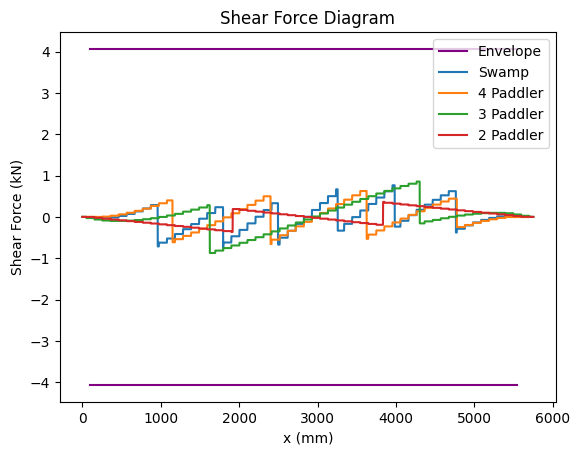

In [3]:
# Scale by station length to make the curve stretch to mm from stations
plt.plot([x * float(canoe_info[4][1]) for x in range(1,station_no-2,1)], [x for x in shear_capacity], color="purple", label="Envelope")
plt.plot([x * float(canoe_info[4][1]) for x in range(1,station_no-2,1)], [-x for x in shear_capacity], color="purple")

CASE_NAMES = ["Swamp", "4 Paddler", "3 Paddler", "2 Paddler", "Display Stand"]

# Plot all shear force diagrams (2, 3, 4, 6) cases graphed on one graph with the shear_capacity bound 
for i in range(len(PAD_CASE_SHEAR)):
    lenArray = np.array(list())
    shearArray = np.array(list())
    plt.plot(PAD_CASE_LENGTH[i].astype(float), PAD_CASE_SHEAR[i].astype(float)/1000, label=CASE_NAMES[i])

print(shear_capacity[0])

plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (kN)')
plt.legend()
plt.show()

In [4]:
# Negative Tau - This has to be fixed
for input_file in input_files:
    file_path = os.path.join(script_dir, input_file)
    info = pd.read_csv(file_path, header=None)
    print(input_file)

    #x_coor = coordinates[0].iloc[1:] # get rid of [0,0,0]
    x_in = in_coor[0]
    y_in = in_coor[1]
    z_in = in_coor[2]

    x_out = out_coor[0]
    y_out = out_coor[1]
    z_out = out_coor[2]

    station_no = x_out.nunique() # number of stations
    station_out = x_out.unique() # location of each station
    station_in = x_in.unique()

    # Positive Shear
    value = float(info[1][2])
    width = float(info[3][2])
    depth = float(info[4][2])
    target_station = float(info[2][2])

    # Extract Station Information
    Y1_in = []; Z1_in = []
    Y2_in = []; Z2_in = []
    Y1_out = []; Z1_out = []
    Y2_out = []; Z2_out = []

    for k in range(1,station_no-2,1):
        if k == target_station:
            X1_in = station_in[k]
            X2_in = station_in[k+1]
            X1_out = station_out[k]
            X2_out = station_out[k+1]
            
            for i in range(0,len(x_out),1):
                if x_out[i] == X1_out:
                    Y1_out.append(y_out[i])
                    Z1_out.append(z_out[i])

                elif x_out[i] == X2_out:
                    Y2_out.append(y_out[i])
                    Z2_out.append(z_out[i])
                
                if x_in[i] == X1_in:
                    Y1_in.append(y_in[i])
                    Z1_in.append(z_in[i])

                elif x_in[i] == X2_in:
                    Y2_in.append(y_in[i])
                    Z2_in.append(z_in[i])

    # Find y_bar
    volume = 0
    product = 0 # y_bar * Volume
    for i in range(0,len(Y1_out)-1,1):
        #print("Y1 (in, out) : (" + str(Y1_in[i]) + ", " + str(Y1_out[i]) + ")\n" + "Z1 (in, out) : (" + str(Z1_in[i]) + ", " + str(Z1_out[i]) + ")")
        #print("Y2 (in, out) : (" + str(Y2_in[i]) + ", " + str(Y2_out[i]) + ")\n" + "Z2 (in, out) : (" + str(Z2_in[i]) + ", " + str(Z2_out[i]) + ")\n")
        z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
        x = (abs(X1_in-X2_in) + abs(X1_out-X2_out))/2
        y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
        z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

        volume_i = x * y * z
        volume += volume_i
        product += volume_i * z_i

    # ybar of the canoe
    y_bar_top = abs(product/volume)
    y_bar_bottom = depth - y_bar_top

    # Find I
    I = 0
    for i in range(0,len(Y1_out)-1,1):
        z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
        y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
        z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4
        I_i = (1/12*y*z**3 + y*z*(abs(z_i) - y_bar_top)**2) # [mm^4]
        I = I + I_i



    # Find Q
    A_top_total = 0
    A_top_ybar_product = 0

    for i in range(0,len(Y1_out)-1,1):
        z_i = ((Z1_out[i]+Z1_out[i+1]+Z1_in[i]+Z1_in[i+1])/4 + (Z2_out[i]+Z2_out[i+1]+Z2_in[i]+Z2_in[i+1])/4) /2
        y = (abs(Y1_in[i] - Y1_out[i]) + abs(Y1_in[i+1]-Y1_out[i+1]) + abs(Y2_in[i] - Y2_out[i]) + abs(Y2_in[i+1]-Y2_out[i+1]))/4
        z = (abs(Z1_out[i+1]-Z1_out[i]) + abs(Z1_in[i+1]-Z1_in[i]) + abs(Z2_out[i+1]-Z2_out[i]) + abs(Z2_in[i+1]-Z2_in[i]))/4

        if(abs(z) <= abs(y_bar_top)):
            A_top_total += y*z
            A_top_ybar_product += A_top_total * z_i

    A_top_ybar = A_top_ybar_product / A_top_total # mm

    Q = A_top_total * abs(A_top_ybar - y_bar_top) # mm^3

    tau_negative = abs(value * Q / (I * concrete_thickness*2)) # N * mm^3 / mm^4 * mm
                                                    # N/mm^2 = MPa

    torsion_negative = value * width/1000

    print("Tau Negative: " + str(tau_negative) + " MPa\n")


Shear_and_Moment_6 Paddlers.csv
Tau Negative: 13.19189127875765 MPa

Shear_and_Moment_4 Paddlers.csv
Tau Negative: 11.379272335181167 MPa

Shear_and_Moment_2 Paddlers.csv
Tau Negative: 15.002502913977928 MPa

Shear_and_Moment_Display_Stand.csv
Tau Negative: 6.2738531779055675 MPa



In [5]:
# Shear Capacity (per station) = 0.17 * √(Compressive Strength) * Cross-sectional Area